## Operability Analysis of a Membrane Reactor for Methane Aromatizaion and Hydrogen Production

This case study consists of a membrane reactor for direct methane aromatization (DMA-MR)
that allows hydrogen and benzene production from natural gas. This single-unit operation is capable of performing reaction and separation simultaneously, allowing for achieving
higher conversion of hydrogen due to Le'Chatelier's principle.

The DMA-MR model has been extensively studied in process operability analysis due to
its particular potential for system modularization and process intensification, as well as
the challenging modeling due to its inherent nonlinearity.

In this case study, some of pypo's features are highlighted, such as:

-  Inverse mapping using state-of-the-art nonlinear programming solvers (e.g., Ipopt)
-  Support for automatic differentiation
-  Evaluation of operability sets for design and control objectives.

The schematic below {cite}`alves22` depicts the membrane reactor in a nutshell: 

![](dma-schematic.PNG)

Which has the following component mole balances developed {cite}`carrasco15`:

For the tube side in which the reaction takes place:


$$ 
\begin{gathered}
    \frac{d F_{t, C H_4}}{d z}= \eta \, r_1 A_t-\frac{Q}{\alpha_{H_2 / C H_4}}\left(P_{t, C H_4}^{1 / 4}-P_{s, C H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, C_2 H_4}}{d z}=-\eta\,\frac{r_1}{2} A_t+\eta \, r_2 A_t-\frac{Q}{\alpha_{H_2 / C_2 H_4}}\left(P_{t, C_2 H_4}^{1 / 4}-P_{s, C_2 H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, H_2}}{d z}=-\eta \, r_1 A_t- \eta \, r_2 A_t-Q\left(P_{t, H_2}^{1 / 4}-P_{s, H_2}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{t, C_6 H_6}}{d z}=-\eta \, \frac{r_1}{3} A_t-\frac{Q}{\alpha_{H_2 / C_6 H_6}}\left(P_{t, C_6 H_6}^{1 / 4}-P_{s, C_6 H_6}^{1 / 4}\right) \pi D_t
    \end{gathered}
$$

And for the shell side, in which mainly $H_{2}$ permeates to:


$$
\begin{gathered}
    \frac{d F_{s, C H_4}}{d z}=\frac{Q}{\alpha_{H_2 / C H_4}}\left(P_{t, C H_4}^{1 / 4}-P_{s, C H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, C_2 H_4}}{d z}=\frac{Q}{\alpha_{H_2 / C_2 H_4}}\left(P_{t, C_2 H_4}^{1 / 4}-P_{s, C_2 H_4}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, H_2}}{d z}=Q\left(P_{t, H_2}^{1 / 4}-P_{s, H_2}^{1 / 4}\right) \pi D_t \\
    \frac{d F_{s, C_6 H_6}}{d z}=\frac{Q}{\alpha_{H_2 / C_6 H_6}}\left(P_{t, C_6 H_6}^{1 / 4}-P_{s, C_6 H_6}^{1 / 4}\right) \pi D_t
    \end{gathered}
$$

In this case study, an inverse mapping with a plug-flow constraint will be evaluated to obtain a modular design region. Then,
for a given modular design, the OI will be evaluated for a given AIS composed by manipulated variables.

With the stage set, let's start by importing some JAX's modules since we will be building an automatic differentiation-based process model.

In [1]:
import jax.numpy as np
from jax.numpy import pi as pi
from jax.experimental.ode import odeint

Then, defining the kinetic and general parameters for the DMA-MR model:

In [2]:
# Kinetic and general parameters

R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

    
# Molecular weights
MM_B = 78.00     #[g/mol] 

# Fixed Reactor Values
T = 1173.15                 # Temperature[K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flowrate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flowrate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flowrate[cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flowrate [mol/h]

Defining the DMA-MR Model equations (mole balances), compatible with Google's JAX:

In [3]:
def dma_mr_model(F, z, dt,v_He,v0, F_He, Ft0):

    At = 0.25 * np.pi * (dt ** 2)  # Cross sectional area [cm2].
    
    # Avoid negative flows that can happen in the first integration steps.
    # Consequently this avoids that any molar balance (^ 1/4 terms) generates
    # complex numbers.
    F = np.where(F <= 1e-9, 1e-9, F)
    
    

    
    # Evaluate the total flow rate in the tube & shell.
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)

    # Concentrations from molar flow rates [mol/cm3].
    C = F[:4] / v
    # Partial pressures - Tube & Shell [mol/cm3].

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)
    
    

    # First reaction rate.
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / 
                                  (k1 * (C[0])**2 )))
    

    # This replicates an if statement to avoid division by zero, 
    # whenever the concentrations are near zero. JAX's syntax compatible.
    C0_aux = C[0]
    r0 = np.where(C0_aux <= 1e-9, 0, r0)
    

    # Second reaction rate.
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / 
                                  (k2 * (C[1])**3 )))
    

    # Same as before
    C1_aux = C[1]
    r1 = np.where(C1_aux <= 1e-9 , 0, r1)  

    # Molar balances adjustment with experimental data.
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Molar balances dFdz - Tube (0 to 3) & Shell (4 to 7)
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt

    dF1 = 1 / 2 * Cat * r0 * At - Cat * r1 * At 
    - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt

    dF2 = Cat * r0 * At + Cat * r1 * At- (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt

    dF3 = (1 / 3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt

    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt

    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt

    dF6 = (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    
    dFdz = np.array([ dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7 ])

    return dFdz

### Analyzing a modular design region using operability inverse mapping

Defining the outputs based on the integration of the DMA-MR model equations.

AIS/DIS Variables:
- Length [cm]
- Diameter [cm]

AOS/DOS Variables:
- Methane conversion [%]
- Benzene production [mg/h]

Defining a model that takes the ODE system described previously and calculates the AOS variables:

In [4]:
def dma_mr_design(u):


    L =  u[0]                   # Tube length   [cm2]
    dt = u[1]                   # Tube diameter [cm2]

    F_He = Ps * v_He / (R * T)  # Sweep gas molar flow rate [mol/h].

    # Initial conditions.
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince.
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt,v_He,v0, F_He, Ft0, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

Importing PyPO's inverse mapping (NLP-based) module:

In [5]:
from pypo import nlp_based_approach

Defining the following:
- DOS Bounds.
- DOS discretization (resolution).
- lower and upper bound for NLP-based approach.
- Initial estimate for NLP-based approach.

In [6]:
DOS_bounds = np.array([[15,25],
                       [35,45]])

# Discretization Grid - 10x10 grid for DOS.
DOS_resolution =  [10, 10]

# Lower and upper bounds of AIS design variables.
lb = np.array([10,  0.1])
ub = np.array([300, 2])

# Initial estimate for NLP.
u0 = np.array([50, 1])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Defining a nonlinear constraint $L/D \geq 30 $ to the inverse mapping to guarantee
plug-flow operation in the membrane reactor. This will generate an inverse map subject 
to plug flow operation:

In [7]:
def plug_flow(u):
    return u[0] - 30.0*u[1]

con= {'type': 'ineq', 'fun': plug_flow}

Obtaining the feasible desired input/output sets $(DIS^*/DOS^*)$ at each discretized point:

 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian). Make sure your process model is JAX-compatible implementation-wise.


  0%|          | 0/100 [00:00<?, ?it/s]

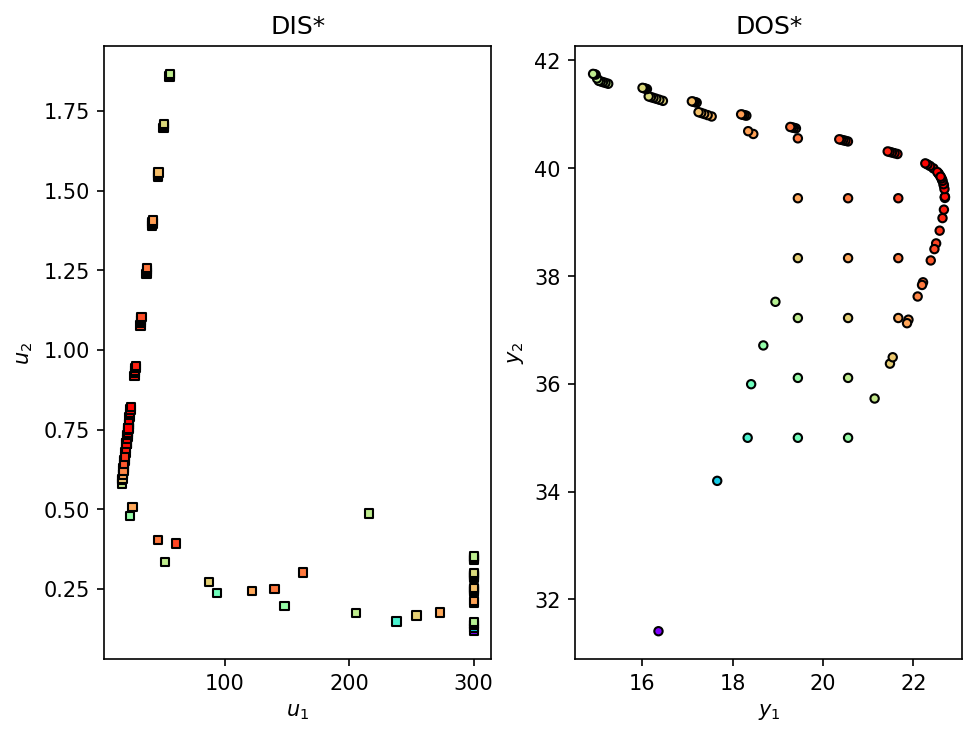

In [8]:
fDIS, fDOS, convergence = nlp_based_approach(dma_mr_design, 
                                             DOS_bounds, 
                                             DOS_resolution,
                                             u0,
                                             lb,
                                             ub,
                                             constr=(con),
                                             method='ipopt',
                                             plot=True,
                                             ad=True,
                                             warmstart=True)

The inverse mapping shows that there is a modular design region of tube length around  $0.55cm$ and a tube diameter of $17cm$ that can still attain the requirement of the DOS.

### Analyzing the Operability Index (OI) for operational changes (manipulated variables)

With a fixed modular design of 
- Tube length = 17 cm
- Tube diameter = 0.55 cm

The manipulated variables of the DMA-MR (namely, shell and tube volumetric flow rates) are
to be analyzed, being the AIS variables for this analysis. As before, the same 
AOS/DOS variables will be kept to observe if the system is operable under the fixed
modular design while varying the manipulated variables throughout their available ranges.

The manipulated variables bounds are both between $450$ and $1500$ $[cm³/h]$.



Let's import PyPO's multimodel approach and OI evaluation modules:

In [9]:
from pypo import multimodel_rep, OI_eval

And define a function to calculate the AIS-AOS for the manipulated variables:

In [10]:
def dma_mr_mvs(u):

    v0  = u[0]                  # Vol. flow rate [cm³ h-¹]
    v_He = u[1]                 # Vol. flow rate[cm³/h]

    # Fixed design variables:
    L =  17.00                  # Tube length   [cm]
    dt = 0.55                   # Tube diameter [cm]

    Ft0 = Pt*v0/(R*T)           # Initial molar flow rate [mol/h] - Pure CH4
    
    F_He = Ps * v_He / (R * T)  # Sweep gas molar flow rate [mol/h]
    

    # Initial conditions and integrator tolerance.
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince.
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt, v_He,v0, F_He, Ft0, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

Obtaining the AOS region using the multimodel representation. 

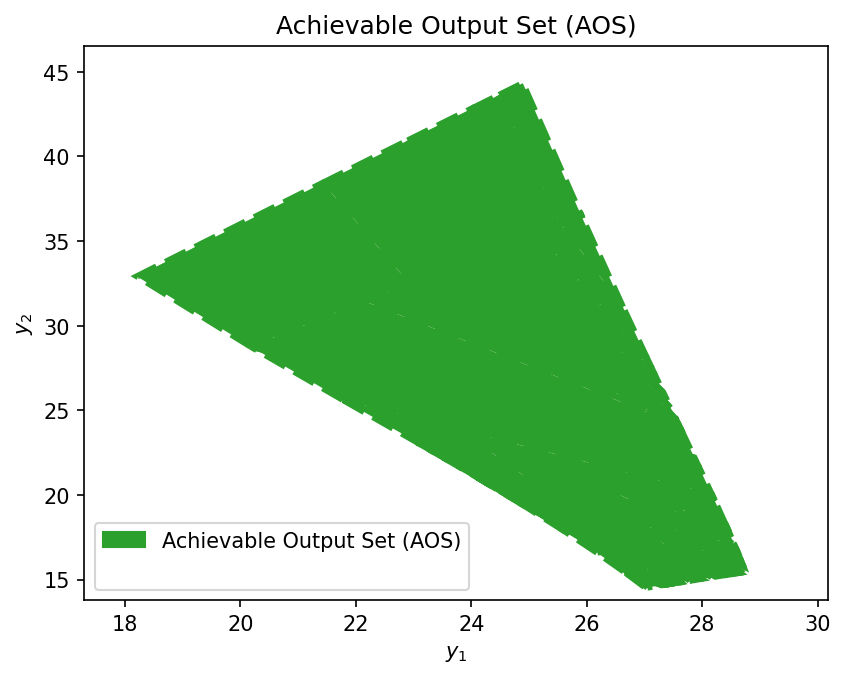

In [11]:
AIS_bounds =  np.array([[450, 1500],
                        [450, 1500]])

AIS_resolution =  [10, 10]

AOS_region  =  multimodel_rep(dma_mr_mvs, AIS_bounds, AIS_resolution)


Evaluation of the OI. The same DOS bounds are used from the inverse mapping task, since our
objective is still to analyze this membrane reactor to operate between $[15 - 25] mg/h$ for the $C_{6}H_{6}$ production,
and $[35-45] \%$ for $CH_{4}$ conversion:

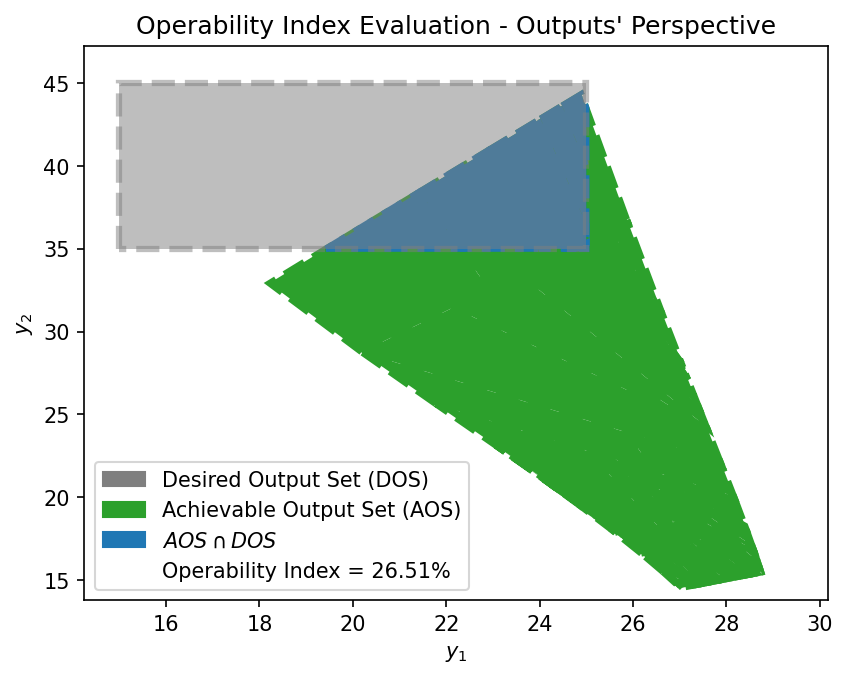

In [12]:
OI = OI_eval(AOS_region, DOS_bounds)

We can see that $26.51\%$ of this DMA-MR modular design is operable when changing the manipulated variables available.
This result is irrespective of the controller type and assesses, using a steady state process model, the maximum achievability
of this membrane reactor. In short, the inverse mapping procedure yielded a modular design region given a plug-flow constraint and
a DOS, and an additional operability analysis for this modular design showed the maximum that it can possible do, under nominal disturbances.